In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          11854        349  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           3765         97  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            781         28  1.0              
thede

In [ ]:
# !kaggle datasets download bulentsiyah/semantic-drone-dataset -p /content/sample_data/ --unzip

100% 3.88G/3.89G [00:31<00:00, 165MB/s]
100% 3.89G/3.89G [00:31<00:00, 132MB/s]


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_PATH = '../content/sample_data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../content/sample_data/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


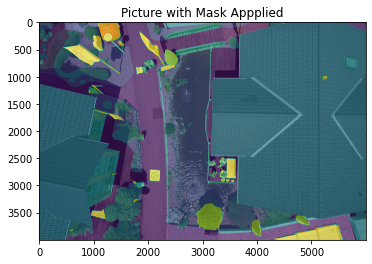

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
class DroneDataset(Dataset):

  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)

batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
class U_net(nn.Module):
  def __init__(self):
    super(U_net, self).__init__()
    self.block1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block2 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block3 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block4 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block5 = nn.Sequential(
      nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block6 = nn.Sequential(
      nn.Conv2d(1024, 512, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(512, 512, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block7 = nn.Sequential(
      nn.Conv2d(512, 256, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block8 = nn.Sequential(
      nn.Conv2d(256, 128, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.block9 = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(64, 23, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool = nn.MaxPool2d(2, 2)
    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, padding = 'same')
    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, padding = 'same')
    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, padding = 'same')
    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, padding = 'same')


  def forward(self, x):
    x1 = self.block1(x)

    x2 = self.pool(x1)
    x2 = self.block2(x2)

    x3 = self.pool(x2)
    x3 = self.block3(x3)

    x4 = self.pool(x3)
    x4 = self.block4(x4)

    x5 = self.pool(x4)
    x5 = self.block5(x5)

    x6 = torch.cat((x4, self.upconv1(x5)), 3)
    x6 = self.block6(x6)

    x7 = torch.cat((x3, self.upconv2(x6)), 3)
    x7 = self.block7(x7)

    x8 = torch.cat((x2, self.upconv3(x7)), 3)
    x8 = self.block8(x8)

    x9 = torch.cat((x1, self.upconv4(x8)), 3)
    return F.self.block8(x9)

In [ ]:
model = U_net()
model

In [ ]:
optimizer = torch.optim.Adam()
loss = nn.CrossEntropyLoss()
epochs = 15

In [ ]:
def fit():
    running 
    train_losses = []
    test_losses = []
    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
      since = time.time()
      model.train()
        for i, data in enumerate(tqdm(train_loader)):
          image_tiles, mask_tiles = data
          image = image_tiles.to(device); mask = mask_tiles.to(device);
          
          output = model(image)
          loss = criterion(output, mask)
          optimizer.step()           
          optimizer.zero_grad()